In [125]:
import torch as th
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, scatter
device = th.device('cpu')
P = 3
R = 3
Q = 701
N1 = 51
N2 = 51
N3 = 51
N4 = 140

METER = 1e9
SEC = 1
LAMBDA = 670e-9 * METER
K = 2 * np.pi / LAMBDA
MUL = lambda x: th.exp(1j * K * x) / x
dtype = th.complex128
real = th.float64

In [126]:
width1, width2, width3, width4 = \
85e-6 * METER, 85e-6 * METER, 1778e-6 * METER, 85e-6 * METER
x1, x2 = \
0.009815 * METER, 0.489 * METER

In [127]:
# position1 = np.linspace(1e-3 * METER, 10e-3 * METER, N1)
# position2 = np.linspace(2e-3 * METER, 10e-3 * METER, N2)
# position3 = np.linspace(1e-3 * METER, 10e-3 * METER, N3)
# position4 = np.linspace(1e-3 * METER, 10e-3 * METER, N4)

# field1 = th.tensor(np.linspace(position1, position1 + width1, P), dtype=dtype, device=device)
# field2 = th.tensor(np.linspace(position2, position2 + width2, P), dtype=dtype, device=device)
# field3 = th.tensor(np.linspace(position3, position3 + width3, Q), dtype=dtype, device=device)
# field4 = th.tensor(np.linspace(position4, position4 + width4, R), dtype=dtype, device=device)

# E1 = th.ones_like(field1, dtype=dtype, device=device) # P, N1
# E2 = th.ones_like(field2, dtype=dtype, device=device)

# D1 = th.sqrt(x1 ** 2 + (field1[:, None, :, None]-field3[None, :, None, :]) ** 2) 
# # P, Q, N1, N3
# D2 = th.sqrt(x1 ** 2 + (field2[:, None, :, None]-field3[None, :, None, :]) ** 2)
# # P, Q, N2, N3
# D3 = th.sqrt(x2 ** 2 + (field3[:, None, :, None]-field4[None, :, None, :]) ** 2)
# # Q, R, N3, N4

# E3 = th.einsum('pqnr,pn->qnr', MUL(D1), E1)[:, :, None, :] \
#   + th.einsum('pqnr,pn->qnr', MUL(D2), E2)[:, None, :, :]
# # Q, N1, N2, N3

# E4 = th.einsum('qrmn,qklm->rklmn', MUL(D3), E3)
# # R, N1, N2, N3, N4

# result = th.abs(E4)
# result = th.sum(result, dim=0)
# plt.plot(position4 / METER * 1e3, result[6, 7, 5, :].to("cpu").numpy())
# print("hole1: ", position1[6], position1[6] + width1)
# print("hole2: ", position2[7], position2[7] + width2)
# print("hole3: ", position3[5], position3[5] + width3)


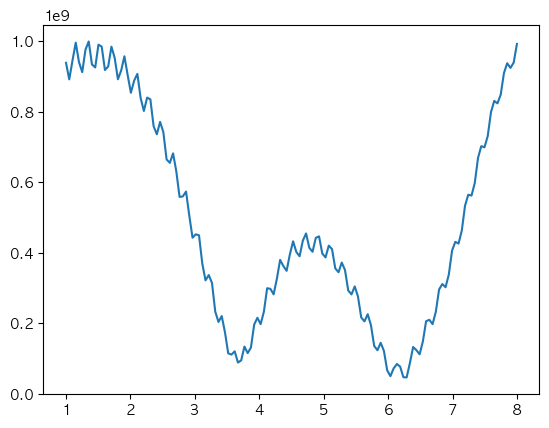

In [128]:
position1 = np.linspace(1e-3 * METER, 10e-3 * METER, N1)
position2 = np.linspace(16e-3 * METER, 10e-3 * METER, N2)
position3 = np.linspace(1e-3 * METER, 10e-3 * METER, N3)
position4 = np.linspace(1e-3 * METER, 8e-3 * METER, N4)

field1 = th.tensor(np.linspace(position1, position1 + width1, P), dtype=dtype, device=device)
field2 = th.tensor(np.linspace(position2, position2 + width2, P), dtype=dtype, device=device)
field3 = th.tensor(np.linspace(position3, position3 + width3, Q), dtype=dtype, device=device)
field4 = th.tensor(np.linspace(position4, position4 + width4, R), dtype=dtype, device=device)

E1 = th.ones_like(field1, dtype=dtype, device=device) # P, N1
E2 = th.ones_like(field2, dtype=dtype, device=device)

D1 = th.sqrt(x1 ** 2 + th.square(field1[:, None, :, None]-field3[None, :, None, :])) 
# P, Q, N1, N3
D2 = th.sqrt(x1 ** 2 + th.square(field2[:, None, :, None]-field3[None, :, None, :]))
# P, Q, N2, N3
D3 = th.sqrt(x2 ** 2 + th.square(field3[:, None, :, None]-field4[None, :, None, :]))
# Q, R, N3, N4

E3 = th.einsum('pqnr,pn->qnr', MUL(D1), E1)[:, :, None, :] \
  + th.einsum('pqnr,pn->qnr', MUL(D2), E2)[:, None, :, :]
# Q, N1, N2, N3

E4 = th.einsum('qrmn,qklm->rklmn', MUL(D3), E3)
# R, N1, N2, N3, N4

result = th.abs(E4)
result = th.sum(result, dim=0)
max_val, _ = th.max(result, dim=3)
result = result / max_val[:, :, :, None]
plt.plot(position4 / METER * 1e3, result[0, 0, 0, :].to("cpu").numpy() * METER)

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic') 			## 이 두 줄을 
plt.rcParams['axes.unicode_minus'] = False  ## 추가해줍니다. 

path = "./LASER/B-1/"
filename = lambda x: path + "B-1_DoubleSlit_" + str(x) + ".csv"
POSITION_COL = "detector_position(mm)"
VOLTAGE_COL = "voltage(V)"
MILIVOLTE_COL = "voltage(mV)"

def get_data(x):
  data = pd.read_csv(filename(x))
  if MILIVOLTE_COL in data.columns:
    data[VOLTAGE_COL] = data[MILIVOLTE_COL] / 1000
  data = data[data[POSITION_COL] < 8]
  pos = data[POSITION_COL]
  volt = data[VOLTAGE_COL]
  return pos, volt

def plot_data(x):
  pos, volt = get_data(x)
  # plt.plot(pos, volt, color='red', linestyle='solid', marker='o', mfc='black', mec='black', ms=3)
  plt.scatter(pos, volt, color='black', s=4)
  plt.xlabel("Detecor Position (mm)")
  plt.ylabel("Output Voltage (V)")
  plt.title(f"Detecor Position vs Output Voltage({str(x)}호)")

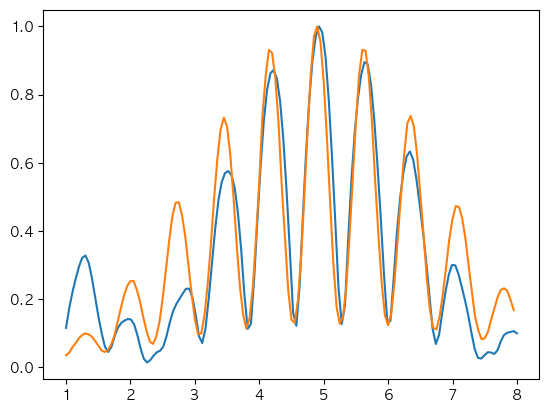

In [130]:
pos, volt = get_data(16)
volt = np.array(volt)
volt = volt / np.max(volt)
volt = th.tensor(volt, dtype=real, device=device)
error = (th.sum(th.square(result-volt), dim=3))
# error min 위치
arg = th.argmin(error)
plot(position4/ METER * 1e3, result.view(-1, N4)[arg])
plot(pos, volt)